In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
device = 'cpu'

In [2]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the spectrum of the windowed input signal
  spectrum = fft(sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  plt.plot(magnitude_spectrum)
  plt.ylabel('amplitude (dB)')
  plt.show()

def signal2pytorch(x):
    #Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [3]:
# define model graph

class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        # Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank, deconvolution
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # pass the input signal through the convolutional layer
        x = self.conv1(x)
        # use the tanh activation function
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        # Synthesis
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        y=self.encoder(x)
        xrek=self.decoder(y)
        return xrek

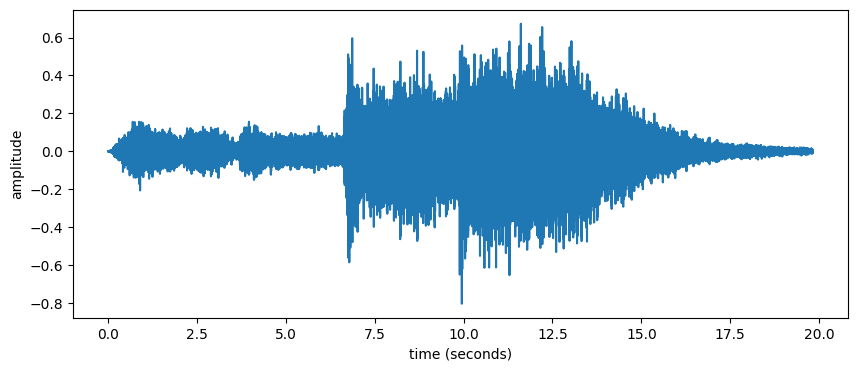

In [4]:
# read training data
batch=1
audio1, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-1.wav")
X_train = signal2pytorch(audio1).to(device)
display_sound(audio1, samplerate)

In [5]:
# Generate Model
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()

Ypred = model(X_train)

# length of the signal at the output of the network.
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)

# the target signal with same length as model output
Y=X_train[:,:,:outputlen]

print("Input X.shape =", X_train.shape)
print("Target Y.shape =", Y.shape)
print("Target Y =", Y)
print("Y.type() =", Y.type())

Total number of parameters: 131105
outputlen= 873474
Input X.shape = torch.Size([1, 1, 874006])
Target Y.shape = torch.Size([1, 1, 873474])
Target Y = tensor([[[-0.0003, -0.0003, -0.0003,  ..., -0.0068, -0.0069, -0.0069]]])
Y.type() = torch.FloatTensor


In [6]:
# train model
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred = model(X_train)
print("Ypred=", Ypred)

# train the model over a number of epochs
nepocs = 2000
for epoch in range(nepocs):
  Ypred=model(X_train)
  loss=loss_fn(Ypred, Y)
  if epoch%10==0:
    print(epoch, loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Ypred= tensor([[[0.0105, 0.0116, 0.0111,  ..., 0.0125, 0.0112, 0.0120]]],
       grad_fn=<ConvolutionBackward0>)
0 0.009954685345292091
10 0.009613998234272003
20 0.00900136400014162
30 0.008122371509671211
40 0.007197185885161161
50 0.006393684074282646
60 0.005746445152908564
70 0.005244244355708361
80 0.00486097764223814
90 0.004576919134706259
100 0.004372702911496162
110 0.004226497374475002
120 0.00411727000027895
130 0.004028966184705496
140 0.003951030783355236
150 0.003876868635416031
160 0.00380248692817986
170 0.003725622780621052
180 0.003645226126536727
190 0.003561125136911869
200 0.003473748220130801
210 0.0033838858362287283
220 0.003292483277618885
230 0.0032004965469241142
240 0.003108822274953127
250 0.0030182807240635157
260 0.0029296146240085363
270 0.0028434658888727427
280 0.0027603465132415295
290 0.002680607372894883
300 0.0026044377591460943
310 0.0025318763218820095
320 0.002462846226990223
330 0.002397188451141119
340 0.0023346971720457077
350 0.002275143284

ww= OrderedDict({'conv1.weight': tensor([[[ 0.0058,  0.0032,  0.0338,  ...,  0.0381,  0.0458,  0.0405]],

        [[-0.0819, -0.0571, -0.0585,  ..., -0.0358, -0.0485, -0.0522]],

        [[-0.0483, -0.0088, -0.0134,  ..., -0.0110,  0.0006,  0.0426]],

        ...,

        [[ 0.0219,  0.0388,  0.0320,  ...,  0.0119,  0.0085,  0.0290]],

        [[ 0.0198,  0.0127,  0.0461,  ...,  0.0459,  0.0501,  0.0465]],

        [[ 0.0120, -0.0057, -0.0044,  ..., -0.0063, -0.0292, -0.0236]]]), 'conv1.bias': tensor([ 3.8198e-04, -1.1691e-03,  1.7989e-03,  1.1706e-03, -8.6751e-04,
         2.5354e-04, -4.0946e-04, -5.9294e-05, -7.2446e-04, -3.6139e-04,
         9.7662e-04,  3.5259e-05, -4.5390e-05,  1.4525e-03, -1.1939e-04,
        -5.0097e-04, -1.3351e-03, -4.6893e-04,  5.1347e-04,  5.9204e-04,
        -1.2670e-03, -8.4568e-04,  1.5194e-04, -1.3809e-03,  3.6685e-04,
        -4.6877e-04,  2.6221e-04, -2.9078e-04,  8.6009e-04,  9.1321e-04,
         1.4338e-03, -3.8076e-04]), 'synconv1.weight': tensor(

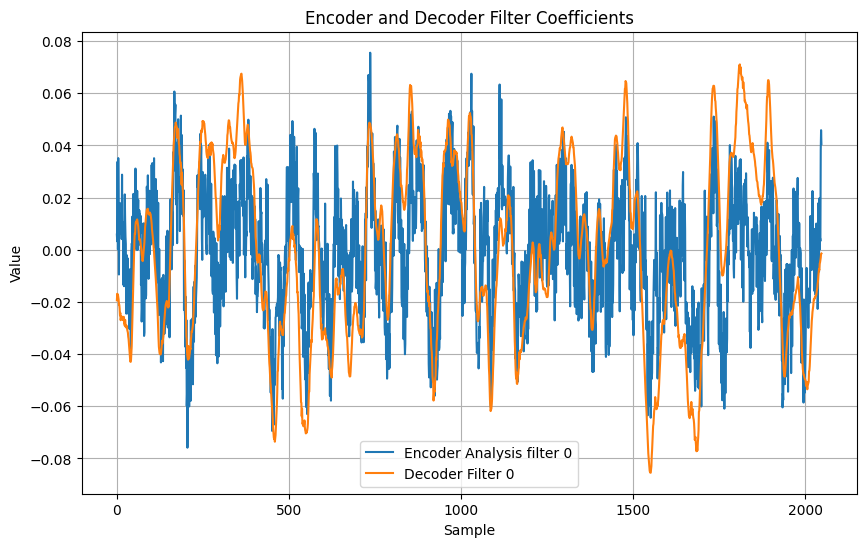

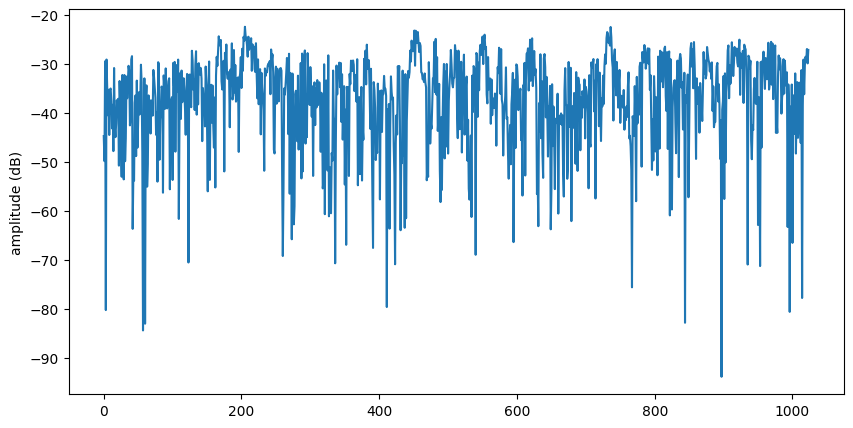

predictions.shape= (1, 1, 873474)


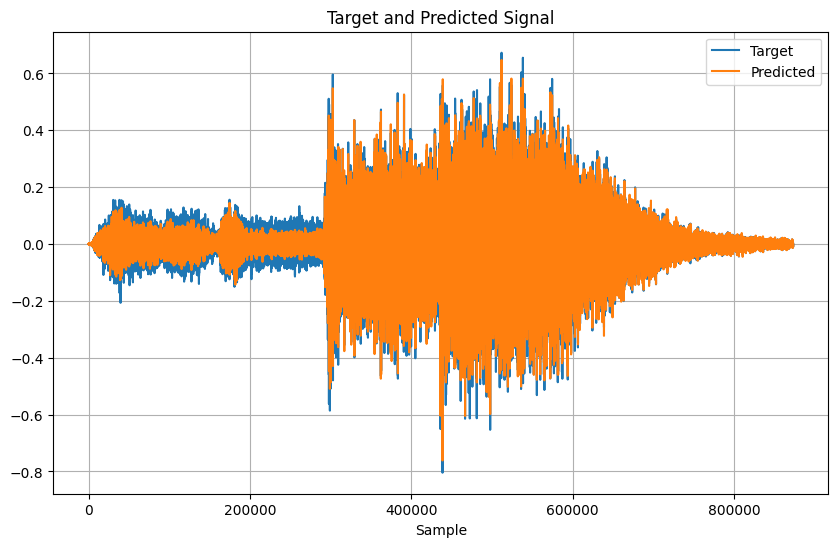

In [7]:
# make predictions using the training set

#read obtained weights
ww = model.state_dict()
print("ww=", ww)

#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.grid()

display_spectrum(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])), 44100)


# Make Predictions based on the obtained weights, on training set
predictions = model(X_train).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
Y=np.array(Y) #target
print("predictions.shape=", predictions.shape)
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Target','Predicted'))
plt.title('Target and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
#remove unnecessary dimension for playback
xrek=predictions[:,0,:]

In [8]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

In [9]:
#Test on data different from the training one

# audio2, samplerate = read_sound("/content/audio-coding-materials/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("/content/audio-coding-materials/sinewave.wav")
X_test=signal2pytorch(audio2).to(device) #Convert to pytorch format, batch is first dimension

# Make Predictions based on the obtained weights, on verification set
predictions = model(X_test).cpu()
predictions = predictions.detach()
predictions = np.array(predictions)
plt.figure(figsize=(10,6))
plt.plot(np.array(X_test[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]

FileNotFoundError: [Errno 2] No such file or directory: '/content/audio-coding-materials/sinewave.wav'

In [ ]:
#play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

In [ ]:
!pip install torchviz
from torchviz import make_dot

# Define the Convautoenc model
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        # Analysis Filterbank with downsampling
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True)

        # Synthesis filter bank
        self.synconv1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # Analysis
        x = self.conv1(x)
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        # Synthesis
        xrek = self.synconv1(y)
        return xrek

    def forward(self, x):
        y = self.encoder(x)
        xrek = self.decoder(y)
        return xrek

# Create model and dummy input
model = Convautoenc()
x = torch.randn(1, 1, 8192)  # Dummy input (batch_size=1, channels=1, sequence_length=8192)

# Forward pass to create the graph
y = model(x)

# Generate and visualize the computation graph
graph = make_dot(y, params=dict(list(model.named_parameters())))

# Save the graph to a file
graph.render("convautoenc_model_plot", format="png")


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=c99e58841bdfc5e3b4609bb4749b828ce72a740ddca12ddb0a6be7f4a6c546af
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


'convautoenc_model_plot.png'